In [7]:
import torch
import torchvision

import matplotlib.pyplot as plt
import torch
import torchvision

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms

from torch import nn
from torchvision import transforms

from torchinfo import summary

from HelperFunctions import download_data, set_seeds, plot_loss_curves

In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [9]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi")

train_dir = image_path / "train"
test_dir = image_path / "test"
     
train_dir, test_dir

[INFO] data\pizza_steak_sushi directory exists, skipping download.


(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [10]:
IMG_SIZE = 224
transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])

In [11]:
BATCH_SIZE = 32

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_datset = datasets.ImageFolder(test_dir, transform=transform)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloder = DataLoader(dataset=test_datset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

len(train_dataset),len(test_datset),len(train_dataloader), len(test_dataloder)

(225, 75, 8, 3)

(-0.5, 223.5, 223.5, -0.5)

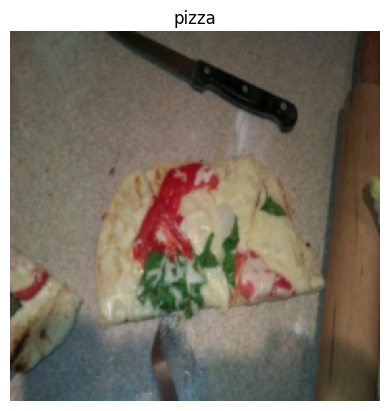

In [12]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.title(train_dataset.classes[label])
plt.axis(False)

In [13]:
height = 224
width = 224
color_channels = 3
patch_size = 16 

number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [14]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


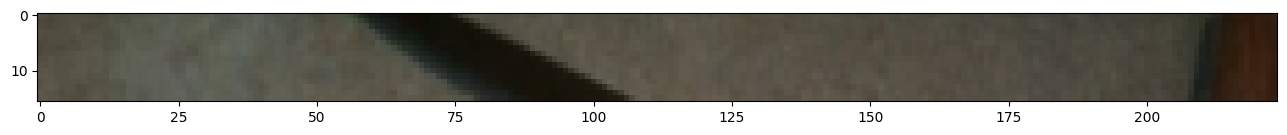

In [15]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


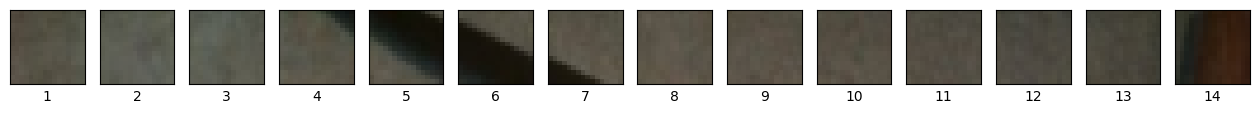

In [34]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

In [24]:
image.shape

torch.Size([3, 224, 224])

In [33]:
height = 224
width = 224
image_size = height * width
patch_size = 16

num_patches = image_size // patch_size**2

fig, axs = plt.subplots(nrows=patch_size, ncols=patch_size, sharex=True, sharey=True, figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, ))

SyntaxError: expected ':' (4110849521.py, line 10)